# Loading modules and downloading data

You may skip this step if the competition data is already present in the directory "./data/"

In [0]:
"#IMPORTANT: NEEDS KAGGLE API KEY UPLOADED IN ROOT DIRECTORY

!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

!mkdir data
!kaggle competitions download -p data/ -c modified-mnist

!unzip -d data/ 'data/*.zip'

# Creating segmented digits

This is performing the operations in order ot extract digits from the original image. More details can be found in the report.

In [0]:
import numpy as np
from skimage.measure import label, regionprops
from numpy.random.mtrand import randint
from skimage.transform import *
from skimage.morphology import *
from random import randrange

digit_threshold = np.vectorize(lambda x: 255 if x > 220 else 0)

def digit_extractor(source, top_clusters=3, combine_unmasked = False):
    source = np.reshape(source, (128,128))

    threshold_img = digit_threshold(source)
    declustered_img = remove_clusters_below_size(threshold_img, size=5)
    dilated_img = dilation(declustered_img)
    labelled_img = label(dilated_img, connectivity = 2)

    nb_clusters = np.max(labelled_img)

    cluster_list = []
    for i in range(1, nb_clusters + 1): #ignoring background
        cluster_size = np.sum(labelled_img == i)
        cluster_list.append((cluster_size, i))  # append tuple

    cluster_list.sort(reverse=True)

    cluster_imgs = []
    for _, cluster in cluster_list[:top_clusters]:

        mask = labelled_img == cluster
        unmasked = unmask(source, mask)
        cropped_digit = crop(unmasked, mask)
        padded_digit = center_by_bounding_box(cropped_digit)

        padded_digit = np.reshape(padded_digit, (28,28,1))
        if combine_unmasked:
          new_cropped_digit = crop(source, mask, tight=False)
          new_padded_digit = center_by_bounding_box(new_cropped_digit)
          new_padded_digit = np.reshape(new_padded_digit, (28,28,1))
          new_cut_digit = np.concatenate((padded_digit, new_padded_digit), axis=2)
          cluster_imgs.append(new_cut_digit)

        else:
          cluster_imgs.append(padded_digit)

    while len(cluster_imgs) < 3:
      cluster_imgs.append(np.zeros((28,28,1)) if not combine_unmasked
                          else np.zeros((28,28,2)))
    return np.array(cluster_imgs)

def unmask(source, mask):
    return source * mask

def crop(source, mask, tight=True):
    width = source.shape[0]
    height = source.shape[1]

    h_presence = np.sum(mask, axis=0)
    v_presence = np.sum(mask, axis=1)

    h_min = min([i for i in range(width) if h_presence[i]])
    h_max = max([i for i in range(width) if h_presence[i]])

    v_min = min([i for i in range(height) if v_presence[i]])
    v_max = max([i for i in range(height) if v_presence[i]])
    
    if tight:
      return source[v_min:v_max, h_min:h_max]

    else:
      digit_width = h_max - h_min
      digit_height = v_max - v_min

      if digit_width < 28:
        padding = int((28 - digit_width) / 2)

        h_min_bound = h_min - padding
        h_max_bound = h_max + padding

      else:
        h_min_bound = h_min
        h_max_bound = h_max

      if digit_height < 28:
        padding = int((28 - digit_width) / 2)

        v_min_bound = v_min - padding
        v_max_bound = v_max + padding

      else:
        v_min_bound = v_min
        v_max_bound = v_max

      return source[v_min_bound:v_max_bound, h_min_bound:h_max_bound]



def center_by_bounding_box(source, box_size=28):
    height = source.shape[0]
    width = source.shape[1]

    cropped_source = source

    if height > box_size:
        excedent = int((height - box_size)/2)
        cropped_source = cropped_source[excedent:excedent+box_size, : ]

        height = box_size

    if width > box_size:
        excedent = int((width - box_size) / 2)
        cropped_source = cropped_source[ : , excedent:excedent + box_size]

        width = box_size

    canvas = np.zeros((box_size, box_size))  # zero array of size box_size

    height_pad = int((box_size - height) / 2)
    width_pad = int((box_size - width) / 2)

    canvas[height_pad:height_pad + height, width_pad:width_pad + width] = cropped_source

    return canvas


def remove_clusters_below_size(img, size=5):
    labelled_img, nb_clusters = label(img, connectivity=2, return_num=True)
    cluster_ids_to_eliminate = [0]  # 0 is the background cluster

    for i in range(1, nb_clusters):
        cluster_size = np.sum(labelled_img == i)

        if size is not None and cluster_size <= size:
            cluster_ids_to_eliminate.append(i)

    elimination_map = lambda x: 0 if x in cluster_ids_to_eliminate else 255
    vem = np.vectorize(elimination_map)
    declustered_img = vem(labelled_img)
    return declustered_img


#Creating the data generator

The raw images are augmented by rotations, translations and grid distortions. The augmented images then have segmented digits pulled from them, as well as the surrounding box, in order to create the two-channel input for the model.

In order to avoid taking too much RAM, these augmentations and the digits segmentations are computed in advance. I used 6 batches of augmentationss by default, providing 264k training examples from an original set of 44k (the rest being used for validation).

This operation may take up to an hour as it runs on CPU and is not multithreaded. Make sure to have about 20 GB of disk space at your disposal.

---

Display output: 100 examples.
* Absolute value difference between original image and augnemted image
* Original image
* Three segmented digits, two channel images
* Corresponding *y* value.







In [0]:
%tensorflow_version 2.x
!pip install albumentations==0.4.2

import cv2
from albumentations import Compose, ToFloat, ShiftScaleRotate, ElasticTransform, OneOf, Lambda, GridDistortion
from cv2.cv2 import GaussianBlur
from skimage.draw import ellipse
import numpy as np
import numpy.random as rd
from tensorflow.keras.utils import *

import matplotlib.pyplot as plt

import pickle
import pandas as pd
import gc

augmentations = Compose([
    ShiftScaleRotate(rotate_limit=10,
                     scale_limit=(-0.1,0)),
                     #shift_limit=0.05),
    GridDistortion(distort_limit=0.2)
])

class AugmentedDataSequence(Sequence):
    def __init__(self, x_set, y_set, name, batch_size=128, generation_multiple=3, generation_pickles=None):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.batch_number = int(np.floor((len(self.x) + 0.0) / self.batch_size))

        self.generation_number = 0
        self.generations = []

        self.name = name

        if generation_pickles is not None:
          self.generation_multiple = len(generation_pickles)
          self.generations = generation_pickles

        else:
          print("Starting generation process for " + self.name)
          self.generation_multiple = generation_multiple

          for i in range(generation_multiple):
            generation_batch=[]
            for j in range(self.batch_number):
              x_batch = self.x[j * self.batch_size : (j + 1) * self.batch_size]
              y_batch = self.y[j * self.batch_size : (j + 1) * self.batch_size]
              
              augmented_image_batch = [augmentations(image=im)["image"] for im in x_batch]
              augmented_image_batch = np.array(augmented_image_batch)

              digits = np.array([digit_extractor(img, combine_unmasked=True) for img in augmented_image_batch])

              digit_1 = digits[:,0]
              digit_2 = digits[:,1]
              digit_3 = digits[:,2]

              digit_1 = np.reshape(np.array(digit_1), (self.batch_size, 28,28,2)).astype(np.uint8)
              digit_2 = np.reshape(np.array(digit_2), (self.batch_size, 28,28,2)).astype(np.uint8)
              digit_3 = np.reshape(np.array(digit_3), (self.batch_size, 28,28,2)).astype(np.uint8)

              generation_batch.append([(augmented_image_batch, digit_1, digit_2, digit_3), np.array(y_batch)])

              if (j % 10 == 0):
                print(str(j * self.batch_size) + " examples generated")
            
            print("Generator " + self.name + ": Done with batch " + str(i+1) + " of " + str(self.generation_multiple))

            generation_name = self.name + "_batch_" + str(i) + ".pkl"
            generation_file = open(generation_name, "wb")
            pickle.dump(generation_batch, generation_file)
            generation_file.close()

            self.generations.append(generation_name)
            del(generation_batch) 

        del(self.x)
        del(self.y)

        gen_file = open(self.generations[0], "rb")
        self.current_generation = pickle.load(gen_file)
        gen_file.close()


    def __len__(self):
        return self.batch_number

    def __getitem__(self, index):
        data = self.current_generation[index]

        #normalizing
        x_values = tuple(x / 255. for x in data[0])
        return x_values, data[1]

    def on_epoch_end(self):
      self.generation_number = (self.generation_number + 1) % self.generation_multiple

      gen_file = open(self.generations[generation_number], "rb")
      self.current_generation = pickle.load(gen_file)
      gen_file.close()

      n = gc.collect()
      if n > 0:
        print("\nGarbage collection removed " + str(n) + " objects.")

raw_train_file = open("data/train_max_x", "rb")
raw_images = pickle.load(raw_train_file)
raw_train_file.close()
raw_images = np.reshape(np.array(raw_images), (50000, 128, 128, 1))

raw_train = raw_images[:44000]
raw_test = raw_images[44000:]
df = pd.read_csv("data/train_max_y.csv")
y = list(df["Label"])
y = to_categorical(y)
y_train = y[:44000]
y_test = y[44000:]

#train_generator = AugmentedDataSequence(raw_train, y_train, "train",
#                                        batch_size=128, generation_multiple=6)
train_generator = AugmentedDataSequence(raw_train, y_train, "train",
                                        batch_size=128,
                                        generation_pickles=["train_batch_" + str(i) + ".pkl" for i in range(6)])

from google.colab.patches import cv2_imshow
sample_batch, _ = train_generator.__getitem__(0)

def add_channel(img):
  new_img = np.concatenate((np.zeros((img.shape[0], img.shape[1], 1)), img), axis=2)
  return new_img * 255.

for i in range(100):
  cv2_imshow(np.abs(np.reshape(raw_train[i], (128,128)) - np.reshape(sample_batch[0][i], (128,128)) * 255.))
  cv2_imshow(np.reshape(sample_batch[0][i], (128,128)) * 255.)
  cv2_imshow(add_channel(sample_batch[1][i]))
  cv2_imshow(add_channel(sample_batch[2][i]))
  cv2_imshow(add_channel(sample_batch[3][i]))
  print(y_train[i])


The same operations are then performed on the validation set.

In [0]:
test_digits = np.array([digit_extractor(img, combine_unmasked=True) for img in raw_test])

test_digit_1 = test_digits[:,0] / 255.
test_digit_2 = test_digits[:,1] / 255.
test_digit_3 = test_digits[:,2] / 255.

test_set = [raw_test / 255., test_digit_1, test_digit_2, test_digit_3]

from google.colab.patches import cv2_imshow

for i in range(10):
  cv2_imshow(np.reshape(raw_test[i], (128,128)))
  cv2_imshow(add_channel(test_digit_1[i]))
  cv2_imshow(add_channel(test_digit_2[i]))
  cv2_imshow(add_channel(test_digit_3[i]))
  print(y_test[i])

# Building the model

A list of parameters in order to build the model. This uses the Keras Functional interface.

In [0]:
%tensorflow_version 2.x
import pickle
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import pandas as pd
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend

#TF_MASTER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

#resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TF_MASTER)
#tf.contrib.distribute.initialize_tpu_system(resolver)
#strategy = tf.distribute.experimental.TPUStrategy(resolver)

# Layers properties for raw image input
RES_BLOCK_LENGTH_RAW = 2  # Amount of CNN layers before pooling / res occurs for raw images
RES_BLOCK_NUM_RAW = 4  # Amount of res blocks
CNN_WIDTH_RAW = 64  # Width of each CNN layer
CNN_FIRST_WIDTH_RAW = 128

# Layers properties for the segmented digits input
RES_BLOCK_LENGTH_SEGMENTED = 3
RES_BLOCK_NUM_SEGMENTED = 3
CNN_WIDTH_SEGMENTED = 64

DENSE_LAYERS_NUM = 3  # Amount of final dense layers
DENSE_LAYERS_WIDTH = 512  # Width of each such dense layer
DROPOUT = 0.5  # Dropout proportion

OUTPUT_CATEGORIES = 10  # Amount of desired outputs

def load_segmented_digits(names):
    segmented_digits = []
    for filename in names:
        file = open(filename, "rb")
        segmented_digits += pickle.load(file)

        file.close()

    return segmented_digits


# Model builder
def build_model():
    raw_image_input = Input(shape=(128, 128, 1), name="raw_image_input")
    segmented_digit_input = [Input(shape=(28, 28, 2), name="seg" + str(i+1) + "_input") for i in range(3)]

    # building resnet section for raw image input

    previous_layer = Conv2D(CNN_FIRST_WIDTH_RAW, kernel_size=3, padding="same", name="raw_head_1")(raw_image_input)
    previous_layer = Conv2D(CNN_FIRST_WIDTH_RAW, kernel_size=3, padding="same", name="raw_head_2")(previous_layer)
    #previous_layer = BatchNormalization()(previous_layer)
    previous_layer = Conv2D(CNN_FIRST_WIDTH_RAW, kernel_size=3, padding="same", name="raw_head_3")(previous_layer)
    previous_layer = SpatialDropout2D(DROPOUT, name="raw_head_spatial_dropout")(previous_layer)
    previous_layer = MaxPooling2D(pool_size=(2,2), name="raw_head_pooling")(previous_layer)
    #previous_layer = BatchNormalization()(previous_layer)


    for i in range(RES_BLOCK_NUM_RAW):
        for j in range(RES_BLOCK_LENGTH_RAW):
            previous_layer = Conv2D(CNN_WIDTH_RAW * (i+1), kernel_size=3, padding="same",
                                    name="raw_conv_k3_" + str(i+1) +"_" + str(j+1))(previous_layer)
            #previous_layer = BatchNormalization()(previous_layer)

        if i != RES_BLOCK_NUM_RAW - 1: #not final run
          #previous_layer = Conv2D(CNN_WIDTH_RAW, kernel_size=1, padding="same",
          #                         name="raw_conv_k1_" + str(i+1))(previous_layer)
          #previous_layer = BatchNormalization()(previous_layer)
          previous_layer = MaxPooling2D(pool_size=(2,2), name="raw_pooling_" + str(i))(previous_layer)

        #else:
          #previous_layer = Conv2D(CNN_WIDTH_RAW * (i+1), kernel_size=3, padding="same",
          #                        name="raw_conv_k3_final", strides=(2,2))(previous_layer)
          #previous_layer = Conv2D(4, kernel_size=1, padding="same",
          #                          name="raw_conv_k1_final")(previous_layer)
          #previous_layer = MaxPooling2D(name="raw_pooling_final")(previous_layer)
          #previous_layer = BatchNormalization()(previous_layer)
          

    previous_layer = Flatten(name="raw_flatten")(previous_layer)
    previous_layer = Dense(512, activation="relu")(previous_layer)
    previous_layer = BatchNormalization()(previous_layer)
    previous_layer = Dropout(DROPOUT, name="raw_dropout")(previous_layer)
    raw_input_tail = previous_layer

  # building resnet section for segmented digit input
    segmented_input = Input(shape=(28,28,2), name="seg_input")
    previous_layer = segmented_input
    for j in range(RES_BLOCK_NUM_SEGMENTED):
        for k in range(RES_BLOCK_LENGTH_SEGMENTED):
            previous_layer = Conv2D(CNN_WIDTH_SEGMENTED*(j+1), kernel_size=3, padding="same",
                                    name = "seg_conv_k3_" + str(j+1) + "_" + str(k+1))(previous_layer)
            #previous_layer = BatchNormalization()(previous_layer)

        if j != RES_BLOCK_NUM_SEGMENTED - 1:
            previous_layer = SpatialDropout2D(DROPOUT)(previous_layer)
            previous_layer = MaxPooling2D(name="seg_pooling_" + str(j+1))(previous_layer)

        #else:
            #previous_layer = Conv2D(64, kernel_size=1, padding="same",
            #                        name = "seg_conv_k1_final")(previous_layer)
            #previous_layer = BatchNormalization()(previous_layer)
            #previous_layer = MaxPooling2D(name="seg_pooling_final")(previous_layer)

    previous_layer = Flatten()(previous_layer)
    previous_layer = Dense(512, activation="relu")(previous_layer)
    previous_layer = BatchNormalization()(previous_layer)
    previous_layer = Dropout(DROPOUT, name="seg_dropout")(previous_layer)
    segmented_output = previous_layer
    segmented_model = Model(segmented_input, segmented_output)
    #building dense layers at the tail

    segmented_models = [segmented_model(segmented_digit_input[i]) for i in range(3)]

    #merging both networks from either input
    previous_layer = concatenate(segmented_models + [raw_input_tail])
    #previous_layer = concatenate(segmented_models)
    previous_layer = Dropout(DROPOUT, name="merge_dropout")(previous_layer)


    for i in range(DENSE_LAYERS_NUM):
        previous_layer = Dense(DENSE_LAYERS_WIDTH, name="tail_dense_" + str(i + 1))(previous_layer)

    previous_layer = BatchNormalization()(previous_layer)
    previous_layer = Dropout(DROPOUT, name="tail_dropout")(previous_layer)
    last_hidden_layer = previous_layer

    output = Dense(OUTPUT_CATEGORIES, activation="softmax", name="output")(last_hidden_layer)

    model = Model(inputs=[raw_image_input] + segmented_digit_input, outputs=output)

    return model



Compiling the model and displaying information

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
raw_image_input (InputLayer)    [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
raw_head_1 (Conv2D)             (None, 128, 128, 128 1280        raw_image_input[0][0]            
__________________________________________________________________________________________________
raw_head_2 (Conv2D)             (None, 128, 128, 128 147584      raw_head_1[0][0]                 
__________________________________________________________________________________________________
raw_head_3 (Conv2D)             (None, 128, 128, 128 147584      raw_head_2[0][0]                 
____________________________________________________________________________________________

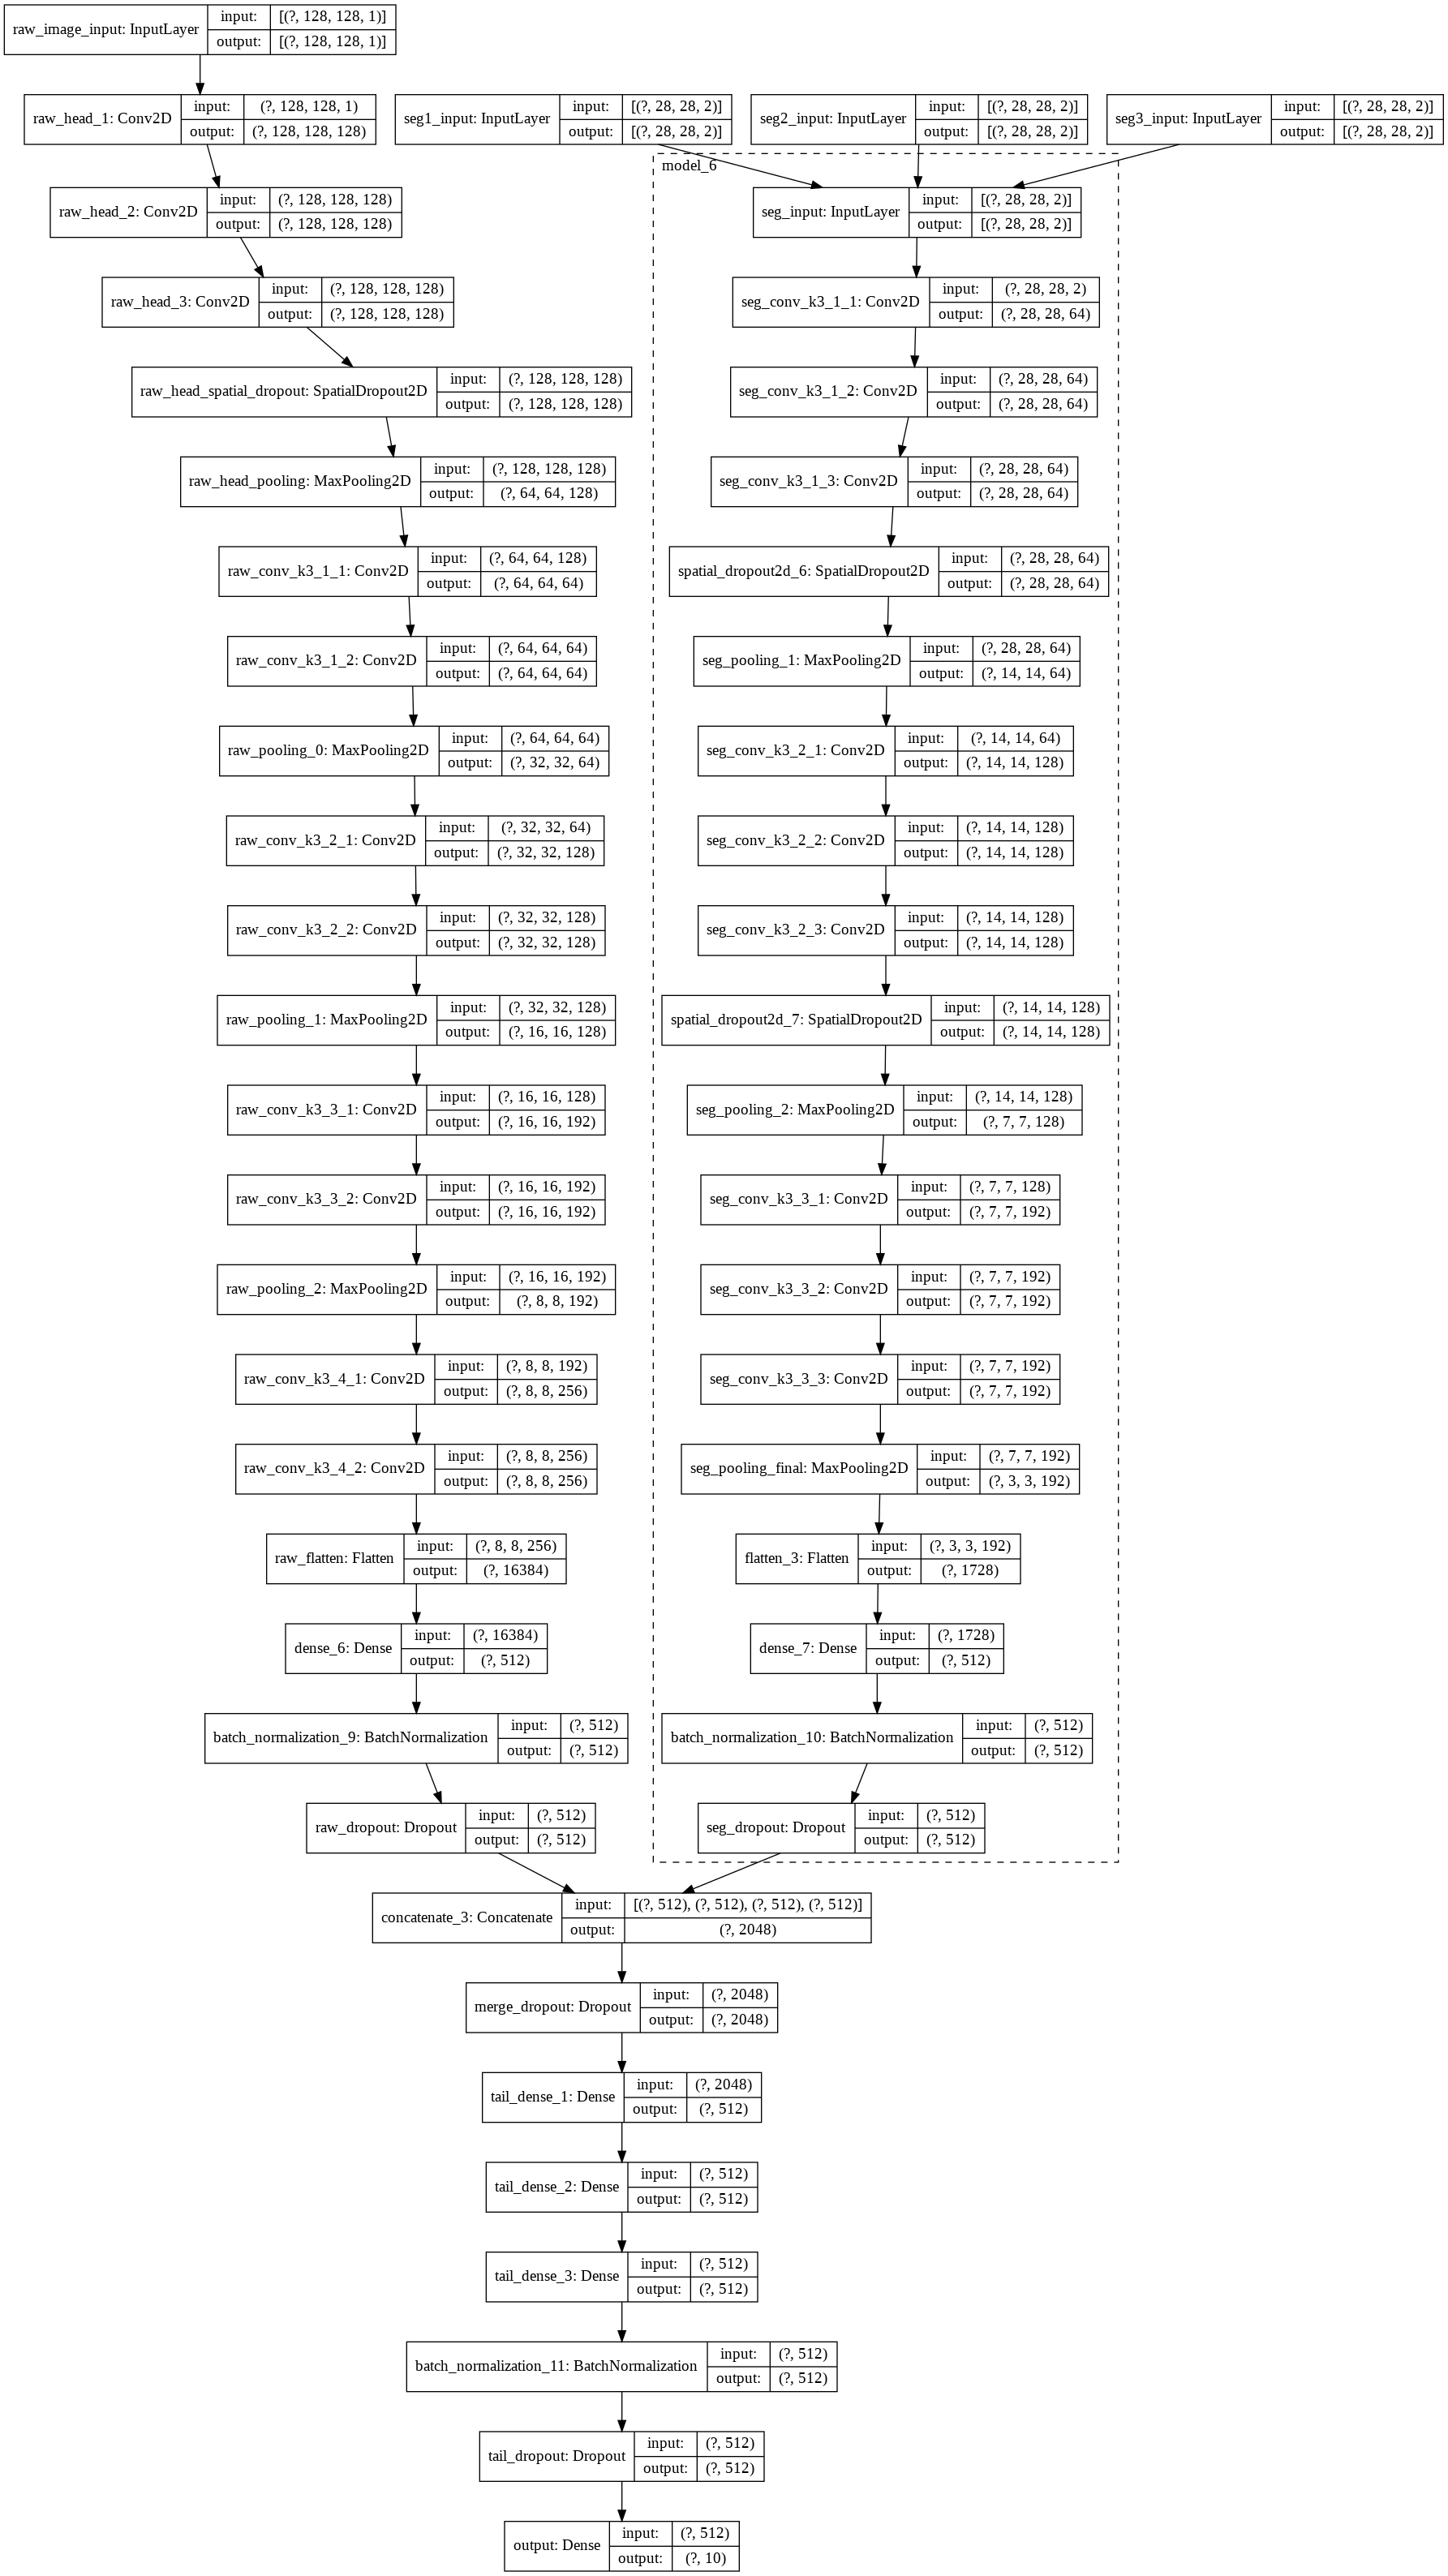

In [0]:
model = build_model()
opt = tf.keras.optimizers.SGD(learning_rate=3e-2, clipnorm=0.1)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()
plot_model(model, expand_nested=True, show_shapes=True)

# Training model and issuing predictions

In [0]:
from tensorflow.keras.callbacks import *

%load_ext tensorboard
%tensorboard --logdir ./logs

model.fit(train_generator,
          validation_data = (test_set, y_test),
          epochs=300,
          callbacks=[ReduceLROnPlateau(monitor="val_accuracy", factor=0.25, patience=6,
                                       verbose=1, min_delta=1e-5),
                     EarlyStopping(monitor="val_accuracy", patience=15,
                                   restore_best_weights=True, verbose=1),
                    TensorBoard(log_dir="./logs", write_images=True, update_freq='batch', profile_batch=0)
                     ],
          use_multiprocessing=True,
          workers=2,
          verbose=1
          )
model.save("model.h5")

Predicting on the test set

In [0]:
import numpy as np

#loading all relevant data
raw_test_file = open("data/test_max_x", "rb")
raw_test_images = pickle.load(raw_test_file)
raw_test_file.close()
test_digits = np.array([digit_extractor(img, combine_unmasked=True) for img in raw_test_images])

test_digit_1 = test_digits[:,0] / 255.
test_digit_2 = test_digits[:,1] / 255.
test_digit_3 = test_digits[:,2] / 255.

raw_test_images = np.reshape(np.array(raw_test_images), (len(raw_test_images), 128, 128, 1)) / 255.

test_set = [raw_test_images, test_digit_1, test_digit_2, test_digit_3]

#using model to predict
pred = model.predict(x = test_set)
pred

Writing to file

In [0]:
#writing predictions to file
write_file = open("multi_cnn_test.csv", "w")
write_file.write("Id,Label\n")

for i, row in enumerate(pred):
  prediction_label = row.tolist().index(max(row))
  write_file.write(str(i) + "," + str(prediction_label) + "\n")

write_file.close()